In [1]:
!pip install requests scikit-learn pubchempy xgboost de seaborn

In [2]:
import os
import requests
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
import pubchempy as pcp
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import os
from deap import base, creator, tools, algorithms
import random
import numpy as np

In [3]:
def get_compound_data(cid):
    compound = pcp.Compound.from_cid(cid)
    smiles = compound.isomeric_smiles
    molecule = Chem.MolFromSmiles(smiles)
    
    if molecule is None:
        raise ValueError(f"Failed to create molecule object: {smiles}")

    descriptors = {
       "CID": cid,
        "MolWt": Descriptors.MolWt(molecule),
        "MolLogP": Descriptors.MolLogP(molecule),
        "NumHDonors": Descriptors.NumHDonors(molecule),
        "NumHAcceptors": Descriptors.NumHAcceptors(molecule),
        "RingCount": Descriptors.RingCount(molecule),
        "TPSA": Descriptors.TPSA(molecule),
        "NumRotatableBonds": Descriptors.NumRotatableBonds(molecule),
        "NumAromaticRings": Descriptors.NumAromaticRings(molecule),
        "NumSaturatedRings": Descriptors.NumSaturatedRings(molecule),
        "NumAliphaticRings": Descriptors.NumAliphaticRings(molecule),
        "NumAromaticHeterocycles": Lipinski.NumAromaticHeterocycles(molecule),
        "NumAliphaticHeterocycles": Lipinski.NumAliphaticHeterocycles(molecule),
        "NumAromaticCarbocycles": Lipinski.NumAromaticCarbocycles(molecule),
        "NumAliphaticCarbocycles": Lipinski.NumAliphaticCarbocycles(molecule),
        "NumHeteroatoms": Descriptors.NumHeteroatoms(molecule),
        "FractionCSP3": Descriptors.FractionCSP3(molecule),
        "HallKierAlpha": Descriptors.HallKierAlpha(molecule),
        "Kappa3": Descriptors.Kappa3(molecule),
        "LabuteASA": Descriptors.LabuteASA(molecule),
        "BalabanJ": Descriptors.BalabanJ(molecule) if Descriptors.BalabanJ(molecule) is not None else 0,  # Handle None values
        "BCUT2D_MWHI": Descriptors.BCUT2D_MWHI(molecule),
        "BCUT2D_MWLOW": Descriptors.BCUT2D_MWLOW(molecule),
        "EState_VSA1": Descriptors.EState_VSA1(molecule),
        "EState_VSA2": Descriptors.EState_VSA2(molecule),
    }

    return descriptors

def get_sdf(cid):
    url = f'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/{int(cid)}/record/SDF'
    response = requests.get(url)
    if response.status_code == 200:
        return response.text
    else:
        print(f'Failed to fetch SDF for CID {int(cid)}: {response.status_code} - {response.reason}')
        return None

In [4]:
def custom_mutate(ind, indpb, min_learning_rate, max_learning_rate):
    # Initialize a flag to keep track of whether any modification occurs
    modified = False
    
    # Mutate the number of estimators (ind[0])
    if random.random() < indpb:
        ind[0] += random.gauss(0, 1)
        ind[0] = max(1, ind[0])  # Make sure n_estimators is at least 1
        modified = True
    
    # Mutate the max depth (ind[1])
    if random.random() < indpb:
        print(f'Before mutation: {ind[1]}')
        ind[1] += random.gauss(0, 1)
        ind[1] = max(0, ind[1])
        print(f'After mutation: {ind[1]}')
        modified = True

    
    # Mutate the learning rate (ind[2])
    if random.random() < indpb:
        ind[2] += random.uniform(0, 0.1)
        ind[2] = max(min_learning_rate, min(max_learning_rate, ind[2]))
        modified = True
    
    # If the learning rate somehow becomes negative, set it to the minimum allowed value
    if ind[2] < 0:
        ind[2] = min_learning_rate

    # Return the modified individual
    return (ind,)

In [5]:
def validate_individual(individual):
    # Ensure all parameters are greater than zero
    return all(param > 0 for param in individual)

In [6]:
def evaluate(individual):
    n_estimators, max_depth, learning_rate = individual
    
    # Validate the individual before using it
    if not validate_individual(individual):
        return float('inf'), # Return a high error
    
    model = xgb.XGBRegressor(n_estimators=int(n_estimators),
                             max_depth=int(max_depth),
                             learning_rate=learning_rate,
                             random_state=42)

    reg = MultiOutputRegressor(model)
    reg.fit(X_train_regressor, y_train_regressor)
    y_pred_regressor = reg.predict(X_test_regressor)
    mae = mean_absolute_error(y_test_regressor, y_pred_regressor)
    return mae,

creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 1, 500)  # Restrict n_estimators and max_depth to positive values
toolbox.register("attr_float", random.uniform, 0.01, 0.2)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_int, toolbox.attr_int, toolbox.attr_float), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register genetic operations
toolbox.register("mate", tools.cxTwoPoint)  # Changed from cxBlend to cxTwoPoint for demonstration
toolbox.register("mutate", custom_mutate, indpb=0.2, min_learning_rate=0.01, max_learning_rate=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)


In [7]:
# Define global variables for use in the notebook
global X_train_regressor, X_test_regressor, y_train_regressor, y_test_regressor

# Load data
data = pd.read_csv('Activity_Types/output_EC50.csv')

# Preprocess and prepare training data
X = data.drop(columns=['CID', 'Activity Type', 'Qualifier', 'Value'])
le = LabelEncoder()
data['Qualifier_encoded'] = le.fit_transform(data['Qualifier'])
y_regressor = data[['Qualifier_encoded', 'Value']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train_regressor, X_test_regressor, y_train_regressor, y_test_regressor = train_test_split(X_scaled, y_regressor, test_size=0.2, random_state=42)

# Evolutionary algorithm part
pop = toolbox.population(n=10)

# Statistical Analysis
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)

# Hall of Fame
halloffame = tools.HallOfFame(maxsize=1)

algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.2, ngen=20,
                    stats=stats, halloffame=halloffame, verbose=True)

# Extract best individual
best_individual = tools.selBest(pop, 1)[0]
print("Best individual before creating model: ", best_individual)
n_estimators, max_depth, learning_rate = best_individual

model = xgb.XGBRegressor(n_estimators=int(n_estimators),
                         max_depth=int(max_depth),
                         learning_rate=learning_rate,
                         random_state=42)

reg = MultiOutputRegressor(model)
reg.fit(X_train_regressor, y_train_regressor)

y_pred_regressor = reg.predict(X_test_regressor)
mse = mean_squared_error(y_test_regressor, y_pred_regressor)
mae = mean_absolute_error(y_test_regressor, y_pred_regressor)

# Fit the model and make predictions
reg.fit(X_train_regressor, y_train_regressor)
y_pred_regressor = reg.predict(X_test_regressor)

# Calculate performance metrics
mse = mean_squared_error(y_test_regressor, y_pred_regressor)
mae = mean_absolute_error(y_test_regressor, y_pred_regressor)
r2 = r2_score(y_test_regressor, y_pred_regressor)  # Calculate R^2 score

# Print performance metrics
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R^2 Score: {r2}')  # Print the R^2 score


gen	nevals	avg    	min    	max    
0  	10    	21.5693	20.9566	25.1669
1  	8     	21.3068	20.9566	23.1194
2  	10    	21.031 	20.9556	21.3774
3  	5     	20.9656	20.9556	21.0027
4  	3     	21.0575	20.9556	21.97  
5  	2     	20.9558	20.9556	20.9566
6  	5     	20.9556	20.9556	20.9556
7  	9     	21.066 	20.9556	22.0596
Before mutation: 93
After mutation: 93.46040159319575
8  	7     	21.0887	20.9556	21.8682
Before mutation: 93
After mutation: 92.63665462835048
9  	7     	21.0436	20.9556	21.4827
10 	5     	20.9556	20.9556	20.9556
Before mutation: 93
After mutation: 90.88509926513584
11 	3     	20.9556	20.9556	20.9556
12 	6     	20.9556	20.9555	20.9556
13 	4     	20.9241	20.6413	20.9556
14 	7     	20.8613	20.6413	20.9556
Before mutation: 93
After mutation: 93.59893025062229
15 	4     	20.7042	20.6413	20.9555
Before mutation: 93
After mutation: 91.6036171783875
16 	4     	20.6413	20.6413	20.6413
17 	4     	20.6413	20.6413	20.6413
18 	6     	20.6413	20.6413	20.6413
19 	2     	20.6413	20.6413	20.6

                     Feature  Importance
18                 LabuteASA    0.343551
10   NumAromaticHeterocycles    0.157629
23               EState_VSA2    0.076495
12    NumAromaticCarbocycles    0.051668
20               BCUT2D_MWHI    0.050275
13   NumAliphaticCarbocycles    0.048400
4                  RingCount    0.040007
5                       TPSA    0.031201
1                    MolLogP    0.029704
21              BCUT2D_MWLOW    0.026763
15              FractionCSP3    0.026759
0                      MolWt    0.020110
14            NumHeteroatoms    0.019390
2                 NumHDonors    0.016890
22               EState_VSA1    0.016126
17                    Kappa3    0.015108
3              NumHAcceptors    0.010031
19                  BalabanJ    0.008015
9          NumAliphaticRings    0.004934
16             HallKierAlpha    0.002548
6          NumRotatableBonds    0.002515
7           NumAromaticRings    0.001412
8          NumSaturatedRings    0.000466
11  NumAliphatic

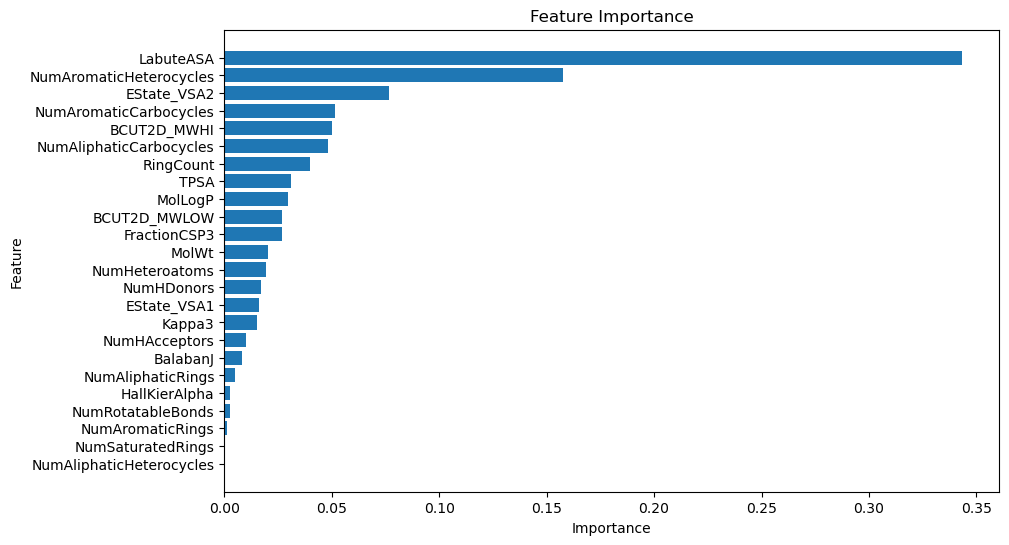

In [8]:
reg.fit(X_train_regressor, y_train_regressor)  # Fit the model

# Get feature importances from the model
feature_importances = reg.estimators_[0].feature_importances_

# Create a DataFrame for the feature importances
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort the features based on importance
features_df = features_df.sort_values(by='Importance', ascending=False)

# Print or display the feature importances
print(features_df)

# Optional: Plot the feature importances for better visualization
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(features_df['Feature'], features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

In [9]:

cid = 168283676
new_data = get_compound_data(cid)
new_data_df = pd.DataFrame([new_data]).drop(columns=['CID'])

new_data_scaled = scaler.transform(new_data_df)
predicted_affinity = reg.predict(new_data_scaled)
predicted_qualifier = le.inverse_transform([int(predicted_affinity[0][0])])

print(f'Predicted EC50 Value [uM]: {predicted_qualifier[0]} {predicted_affinity[0][1]}')


Predicted Qualifier: =
Predicted EC50 Activity Value [uM]: 22.344907760620117
